# データ拡張を実装

In [1]:
# データ処理ライブラリ
import numpy as np
import pandas as pd 

# 画像処理ライブラリ
import cv2

# 可視化ライブラリ
import matplotlib.pyplot as plt

# Keras
import keras as ks
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

# Pythonモジュールと設定
import os
import glob
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Pathの設定
test_path = "./chest_xray/test/"
train_path = "./chest_xray/train/"

# 訓練・テストデータの読み込み
X_train = np.load(train_path + 'X_train.npy')
y_train = np.load(train_path + 'y_train.npy')
X_test = np.load(test_path + 'X_test.npy')
y_test = np.load(test_path + 'y_test.npy')

# 訓練データの拡張

Keras の「ImageDataGenerator」と呼ばれるクラスを使えば、データ拡張を簡単に行えます。
「ImageDataGenerator」は、画像データを任意の「加工」で調整しながら、データを拡張します。
どのような「加工」の方法をとるのかは、訓練データの特性によります。

* rotation_range : 範囲内にランダムで回転
* width_shift_range ： 範囲内でランダムに水平シフト
* height_shift_range : 範囲内でランダムに垂直シフト
* shear_range : 指定した角度でせん断変換
* zoom_range : 範囲内でランダムにズーム
* horizontal_flip : ランダムに水平方向に反転

In [3]:
# ImageDataGeneratorのインスタンス
datagen = ImageDataGenerator(
    rotation_range = 50,
    width_shift_range = .1,
    height_shift_range =.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip=True
)

In [4]:
# 訓練データの画像を加工
i = 0
aug_img = []
for batch in datagen.flow(X_train, shuffle=False, batch_size=2, seed=42):
    i += 1
    aug_img.append(batch)
    if i > 5:
        break

Text(0.5, 1.0, 'Augmented_2')

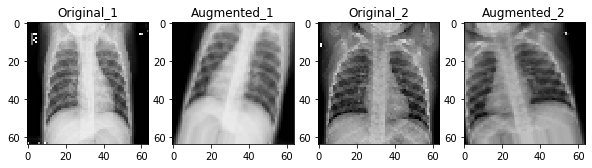

In [5]:
# 確認
fix, ax = plt.subplots(1, 4, figsize=(10, 10))

# 元データ
plt.subplot(141)
plt.imshow(X_train[0])
plt.title('Original_1')

# 拡張データ
plt.subplot(142)
plt.imshow(aug_img[0][0])
plt.title('Augmented_1')

# 元データ_2
plt.subplot(143)
plt.imshow(X_train[1])
plt.title('Original_2')

# 拡張データ_2
plt.subplot(144)
plt.imshow(aug_img[0][1])
plt.title('Augmented_2')

## モデルの訓練

In [6]:
# CNNの構築
aug_model = Sequential()
aug_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(64,64,3)))
aug_model.add(MaxPooling2D(pool_size=(2, 2)))
aug_model.add(Dropout(0.25))
aug_model.add(Flatten())
aug_model.add(Dense(128, activation='relu'))
aug_model.add(Dropout(0.33))
aug_model.add(Dense(1, activation='sigmoid'))

# サマリーを表示
aug_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3936384   
_________________________________________________________________
dropout_2 (Dropout)  

In [7]:
# モデルコンパイル
aug_model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])

In [8]:
# EarlyStoppingの設定
callbacks = EarlyStopping(monitor='val_loss', patience=3)

In [9]:
aug_model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=32, seed=42),
    steps_per_epoch = 163,
    epochs=20,
    verbose=1,
    shuffle=False,
    callbacks=[callbacks],
    validation_data=(X_test, y_test)
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
163/163 [==============================] - 17s 105ms/step - loss: 0.5685 - acc: 0.7404 - val_loss: 0.6204 - val_acc: 0.6250
Epoch 2/20
163/163 [==============================] - 16s 101ms/step - loss: 0.5302 - acc: 0.7488 - val_loss: 0.5877 - val_acc: 0.6266
Epoch 3/20
163/163 [==============================] - 17s 104ms/step - loss: 0.4943 - acc: 0.7632 - val_loss: 0.5053 - val_acc: 0.8205
Epoch 4/20
163/163 [==============================] - 17s 105ms/step - loss: 0.4659 - acc: 0.7843 - val_loss: 0.4606 - val_acc: 0.8205
Epoch 5/20
163/163 [==============================] - 17s 105ms/step - loss: 0.4311 - acc: 0.8067 - val_loss: 0.4261 - val_acc: 0.8446
Epoch 6/20
163/163 [==============================] - 17s 104ms/step - loss: 0.4161 - acc: 0.8137 - val_loss: 0.4090 - val_acc: 0.8413
Epoch 7/20
163/163 [==============================] - 17s 106ms/step - loss: 0.3938 - acc: 0.8261 - val_loss: 0.4125 - val_acc: 0.8429
Epoch 8

## 結果の確認

In [10]:
# ベースラインモデル テストデータで推測結果出力
aug_y_pred = aug_model.predict_classes(X_test)

In [11]:
# 混同行列を算出
confusion_matrix(y_test,aug_y_pred, labels=[1, 0])

array([[305,  85],
       [ 24, 210]], dtype=int64)

In [12]:
# 評価指標 算出
print('正解率：', accuracy_score(y_test, aug_y_pred))
print('適合率：', precision_score(y_test, aug_y_pred))
print('再現率：', recall_score(y_test, aug_y_pred))

正解率： 0.8253205128205128
適合率： 0.9270516717325228
再現率： 0.782051282051282
